# Task 2: Implement a Q-learning Agent to play on a FrozenLake environment.

## Abstract 

We develop a Q-learning Agent class with exponential decay of exploration probability and learning rate. We provide heuristics for the characteristic decaying time and investigate the effect of non-zero asymptotic values. We test the agent on a FrozenLake environment and verify that the provided heuristic is reasonably good, that asymptotic exploration probabilities degrade performance, and asymptotic learning rates degrade sample efficiency.


## Description of the environment

We discuss here the information available in the [description of the environment](https://gym.openai.com/envs/FrozenLake-v0/) that are relevant for our task.

Regarding the environment dynamics, we have the following:

>The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

Therefore, this is a **stochastic** environment, so that the return of a single episode is not an appropriate performance metric. Instead, we will use an *exponentially weighted average* return.

Regargind the rewards:

>The surface is described using a grid like the following:

>SFFF       (S: starting point, safe)

>FHFH       (F: frozen surface, safe)

>FFFH       (H: hole, fall to your doom)

>HFFG       (G: goal, where the frisbee is located)

>The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.

Since there is no penalty for the agent when taking too long to reach the goal, we should set up the parameter $\gamma$ to be less than unity, as this will encourage the agent to finish the task as quickly as possible.

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym

## Creating the environment

In [2]:
env=gym.make('FrozenLake8x8-v0')

# visualize the environment
env.render()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


### Visualizing sample transitions 

In [3]:
for _ in range(5):

    state=env.observation_space.sample()
    print('Sample state:'+str(state))
    for action, transitions in env.P[state].items():
         print("")
         print("Action:"+str(action))
         print("Possible transitions:")
         for transition in transitions:
             print(transition)
    print("#############################################\n")

Sample state:54

Action:0
Possible transitions:
(1.0, 54, 0, True)

Action:1
Possible transitions:
(1.0, 54, 0, True)

Action:2
Possible transitions:
(1.0, 54, 0, True)

Action:3
Possible transitions:
(1.0, 54, 0, True)
#############################################

Sample state:6

Action:0
Possible transitions:
(0.3333333333333333, 6, 0.0, False)
(0.3333333333333333, 5, 0.0, False)
(0.3333333333333333, 14, 0.0, False)

Action:1
Possible transitions:
(0.3333333333333333, 5, 0.0, False)
(0.3333333333333333, 14, 0.0, False)
(0.3333333333333333, 7, 0.0, False)

Action:2
Possible transitions:
(0.3333333333333333, 14, 0.0, False)
(0.3333333333333333, 7, 0.0, False)
(0.3333333333333333, 6, 0.0, False)

Action:3
Possible transitions:
(0.3333333333333333, 7, 0.0, False)
(0.3333333333333333, 6, 0.0, False)
(0.3333333333333333, 5, 0.0, False)
#############################################

Sample state:24

Action:0
Possible transitions:
(0.3333333333333333, 16, 0.0, False)
(0.3333333333333333, 24

From the [Github source](https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py), we know the action meanings are:

* 0: left
* 1: down
* 2: right
* 3: up

Therefore, from these sample transitions, we might infer that the environment dynamics is as follows: after selecting an action a, there is 1/3 probability the agent will manage to do it, 1/3 it will end up executing action a-1 mod 4, and 1/3 it will end up doing action a+1 mod 4. These dynamics simulate slipping.

## Implementing a Q-learning Agent class

We will use the following $\epsilon$ parameter schedule:
$$\epsilon(n)=\epsilon_\infty+(1-\epsilon_\infty)\exp\left(-\frac{n}{n_d}\right),$$

or
$$\epsilon(n+1)=\exp\left(-\frac{1}{n_d}\right)\epsilon(n)+\left(1-\exp\left(-\frac{1}{n_d}\right)\right) \epsilon_\infty, \epsilon(0)=1,$$
where $n$ is the number of episodes the agent has played, and $n_d$ is a decay constant. The goal here is to investigate to what extent the terminal exploration probability $\epsilon_\infty$ impacts the asymptotic performance.

To set a reasonable value for $n_d$, we will follow this heuristic: the more complex the environment is, the more episodes the agent needs to learn something significant about each state-action value. The environment parameters that seem more relevant to characterize such environment complexity are the number of state-action pairs and possible transitions. Therefore, we estimate that the decay constant should be close to:
$$n_d=env.nS*env.nA*\bar{t}$$,
where $\bar{t}$ is the average number of possible transitions after taking some action.

We also note that similar reasoning applies to the learning rate: at the beginning, we want the agent to react strongly to recent rewards since it has no clue about the action values. However, we want the learning process to become smoother as the agent becomes more experienced so that the Q values estimates become stable. However, in general, we want a non-zero terminal value $\alpha_\infty$ because the agent should always be learning at a sensible rate in case the environment dynamics change.  

Therefore, we will also implement a decaying learning rate with a simillar schedule:

$$\alpha(n)=\alpha_\infty+(1-\alpha_\infty)\exp\left(-\frac{n}{n_d}\right),$$

or

$$\alpha(n+1)=\exp\left(-\frac{1}{n_d}\right)\alpha(n)+\left(1-\exp\left(-\frac{1}{n_d}\right)\right) \alpha_\infty, \alpha(0)=1,$$

using the same decay constant of the $\epsilon$ parameter for simplicity.

The terminal values for these parameters are relevant in **non-stationary** environments because we always want exploration and learning at sensible rates to account for the changes in the environmental dynamics. 

However, in this case, we have a **stationary** environment, so that we set these terminal values to 0.0 as default and investigate the effects of non-zero values later on.

In [13]:
class Q_learning_Agent():
    def __init__(self, name, gamma=0.99, alpha_inf=0.0, epsilon_inf=0.0):
        """
        Initialization of a Q-learning Agent.

        Args:
           name: the Agent name (string).
           gamma: the Agent discount factor (float).
           alpha_inf: the Agent asymptotic learning rate (float in [0,1]).
           epsilon_inf: the Agent asymptotic exploratoin probability (float in [0,1])
        """ 
        self.name=name 
        self.gamma=gamma
        self.alpha_inf=alpha_inf
        self.epsilon_inf=epsilon_inf
        self.Q=None #the Agent Q table
        self.history=None #list of the returns the agent obtains on each episode it has played.
        self.nd=None
        self.decay_factor=None 
        self.alpha=None
        self.epsilon=None
        self.previous_state=None
        self.state=None
        self.action=None
    
    def compute_nd(self, env):
        t_avg=0
        for state in range(env.nS):
            for action in range(env.nA):
                t_avg+=len(env.P[state][action])
        t_avg=int(round(t_avg/(env.nS*env.nA)))
        self.nd=t_avg*env.nA*env.nS
    
    def reset_to_env(self,env):
        """
        Should be called whenever the Agent begins to learn how to play in some env.
        """
        self.Q=np.zeros((env.nS,env.nA))
        self.history=[]
        self.compute_nd(env)
        self.decay_factor=np.exp(-1/self.nd) # To avoid calling np.exp at every time step
        self.alpha=1.0
        self.epsilon=1.0

    def play(self, env, episodes, view=False):
        """
        Generates episodes of the agent-environment interaction.
        """
        for _ in range(episodes):
            self.previous_state=None
            self.state = env.reset() #set the initial state
            time_step=0
            episode_return=0.0
            
            while True:
                if view:
                    env.render()
                #select an action (a)
                if np.random.rand()<self.epsilon:
                    self.action=np.random.choice(env.nA)
                else:
                    #argmax with random breaking ties
                    self.action=np.random.choice(np.flatnonzero(self.Q[self.state]==np.amax(self.Q[self.state]))) 

                # Perform the action (a) and observe the outcome state(s') and reward (r)
                self.previous_state=self.state
                self.state, reward, done, info = env.step(self.action)
            
                #update episode_return
                episode_return+=reward*self.gamma**time_step

                # Update the Q table using the Bellman equation: Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
                self.Q[self.previous_state][self.action]+=self.alpha*\
                (reward+self.gamma*np.amax(self.Q[self.state])-self.Q[self.previous_state][self.action])       
              
                #until reaching a terminal state
                if done == True:
                    break
                time_step+=1

            self.epsilon=self.decay_factor*self.epsilon+(1.0-self.decay_factor)*self.epsilon_inf#exponential epsilon decay
            self.alpha=self.decay_factor*self.alpha+(1.0-self.decay_factor)*self.alpha_inf #exponential alpha decay

            self.history.append(episode_return) #save return to agents history


## Tracking the learning process of Olaf, a FrozenLake Q-learning agent

In [15]:
def view_performance_history(agents_list, env, weight=None, episodes=None):
    """
    Agent plays some episodes, then itsperformance history is visualized, where performance is
    defined as an exponentially weighted moving average of the agent returns.

    This process is done for each agent in agents_list

    """
    for agent in agents_list:
        
        agent.reset_to_env(env)

        if weight is None:
            weight=1.0-agent.decay_factor # makes the EWA have the same decay constant of the agents parameters
        if episodes is None:
            episodes=12*agent.nd # 6 nd to ensure exploration has already finished, more 6 nd for the EWA converge to its target value
    
        agent.play(env=env,episodes=episodes)
        performances_list=[agent.history[0]]
        for episode_return in agent.history[1:]:
            performances_list.append(weight*episode_return+(1.0-weight)*performances_list[-1])
        plt.plot(1+np.array(range(len(performances_list))).astype(int), performances_list,'.')
    plt.xlabel('Episodes played')
    plt.ylabel('Performance')
    plt.title("Performance history")
    plt.legend([agent.name for agent in agents_list ])
    plt.show()

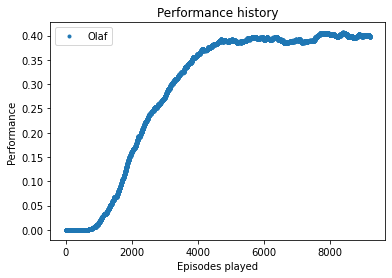

In [16]:
Olaf=Q_learning_Agent(name='Olaf')
view_performance_history(agents_list=[Olaf], env=env)

The asymptotic performance of Olaf is around $P=0.4$. Since the return for a single goal achieved episode is $\gamma^T$, where $T$ is the number of time_steps needed for completion, we can see that, on average, Olaf takes $T=\frac{\log(P)}{\log(\gamma)}\approx 91$ time steps to achieve the goal when playing on its maximum skill level. 

In comparison, if this were a deterministic GridWorld environment, it would take 14 time steps for an optimal agent to finish the task!

## Performance impact of asymptotic exploration probabilities.

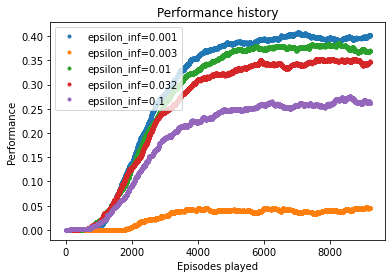

In [17]:
agents_list=[]
for epsilon in np.logspace(-3,-1,num=5, endpoint=True):
    agents_list.append(Q_learning_Agent(name='epsilon_inf='+str(round(epsilon,3)),epsilon_inf=epsilon))

view_performance_history(agents_list=agents_list, env=env)

We see a clear trend in performance degradation when $\epsilon_{\infty}\neq 0$, in spite of the exceptionally bad run for $\epsilon_{\infty}=0,3\%$. However, at least for this problem, this degradation only becomes significant for $\epsilon_{\infty}\approx 3\%$. 

## Performance impact of asymptotic learning rates.

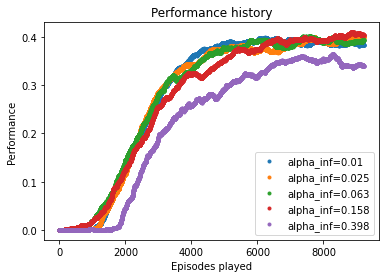

In [18]:
agents_list=[]
for alpha in np.logspace(-2,0,num=5, endpoint=False):
    agents_list.append(Q_learning_Agent(name='alpha_inf='+str(round(alpha,3)),alpha_inf=alpha))

view_performance_history(agents_list=agents_list, env=env)

In contrast to the $\epsilon_\infty$ parameter, a non-zero $\alpha_\infty$ practically does not hurt performance, although for large values ($> 20\%$) the agent becomes much less sample efficient.

## Conclusions

* We demonstrated that a terminal exploration degrades asymptotic performance, although this effect became significant only for $\epsilon_\infty$ around $3\%$ or better in this study.

* In contrast, the $\alpha_\infty$ parameter did not affect the asymptotic performance, but large values significantly diminish sample efficiency.

* The heuristic $n_d=env.nS*env.nA*\bar{t}$ turned out to work quite well, at least in this task. Of course, it will have limitations for larger environments. Nevertheless, even in those cases, it might be useful as a baseline to think about how long it will take for the agent to master a certain environment.